# Описание данных

__Признаки:__
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

__Целевой признак:__
* Price — цена (евро)

# Оглавление
1. [__Подготовка данных__](#preprocessing_data)
    * [__Удаление выбросов__](#clean_data)
        * [_Power_](#Power)
        * [_Price_](#Price)
    * [__Заполнение пропусков__](#Fillna)
    * [__Train/Test split__](#train_test_split)
    * [__Encoding and Scaling__](#Encoding_and_Scaling)
    * [__Вывод__](#Finding_1)
2. [__Обучение моделей__](#model_fit)
    * [__DummyRegressor__](#DummyRegressor)
    * [__LinearRegression__](#LinearRegression)
    * [__CatBoostRegressor__](#CatBoostRegressor)
    * [__LGBMRegressor__](#LGBMRegressor)
    * [__Вывод__](#Finding_2)
3. [__Анализ моделей__](#model_predict)
    * [__Вывод__](#Finding_3)

[__Выводы__](#Finding)

# 1. Подготовка данных <a name='preprocessing_data'></a>

In [138]:
import pandas as pd
import numpy as np
import time
import lightgbm
from scipy.stats import probplot
from catboost import CatBoostRegressor, cv, Pool, train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
data = pd.read_csv('data/autos.csv')

In [23]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [25]:
data.isna().sum(axis=0)

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [26]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Итак план таков:
1. Первое что необъодимо сделать это определить будем ли мы обучаться на нулях в целевом признаке. Думаю правильно удалить все обьекты с нулем, т.к. наврятли клиент захочет продавать свою машину, если модель ему предложит 0.
2. Поработаем над выбросами в признаках Power, RegistrationYear и Price:
2. Выделим целевой признак "Price".
3. Удалим признаки такие как:
    * DateCrawled (дата скачивания анкеты из базы);
    * PostalCode (почтовый индекс владельца анкеты);
    * LastSeen (дата последней активности пользователя);
    * DateCreated (дата создания анкеты);
    * NumberOfPictures (Количество фотографий автомобиля) - в признаке все нули.
4. Разделим данные на тренировочные и тестовые.
5. Сразу определимся с какими моделями будем работать:
    * DummyRegressor;
    * LinearRegression;
    * CatBoostRegressor;
    * LGBMRegressor.
6. Для LinearRegression для категориальных признаков необходимо применить OneHotEncoder. Для остальных моделей прекрасно подойдет OrdinalEncoder.
7. Количественные признаки отмасштабируем при помощи StandardSkaler.

## Удаление выбросов <a name='clean_data'></a>

### Power <a name='Power'></a>

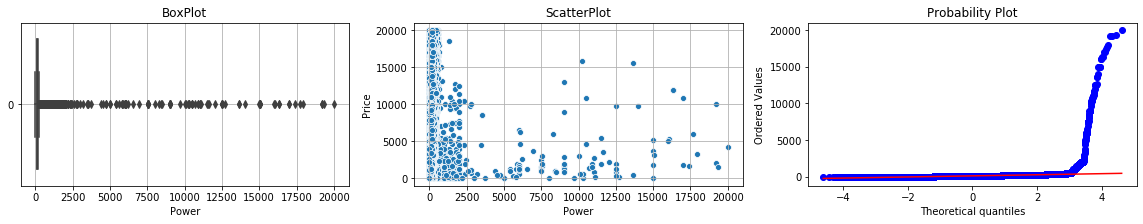

In [28]:
def draw_box_scat_plots(dataset, column1, column2):
    """
    imput:
    dataset - (DataFrame) данные по которым будут строится графики
    column1 - (str) Название основного столбца
    column2 - (str) Название второстепенного столбца
    Строит три графика:
    1 - BoxPlot по столбцу column1
    2 - ScatterPlot по столбцу column1, column2
    3 - qqplot по столбцу column1
    """
    f, ax = plt.subplots(ncols = 3, figsize=(20, 3))
    sns.boxplot(data=dataset[column1], orient='h', ax=ax[0])
    ax[0].set_xlabel(column1)
    ax[0].set_title('BoxPlot')
    ax[0].grid()
    sns.scatterplot(x=column1, y=column2, data=dataset, ax=ax[1]);
    ax[1].set_xlabel(column1)
    ax[1].set_ylabel(column2)
    ax[1].set_title('ScatterPlot')
    ax[1].grid()
    probplot(x=dataset[column1], plot=ax[2])

draw_box_scat_plots(data, 'Power', 'Price')

Кажется будто все выбросы скопились справа. Что бы было более наглядно логарифмируем признак Power

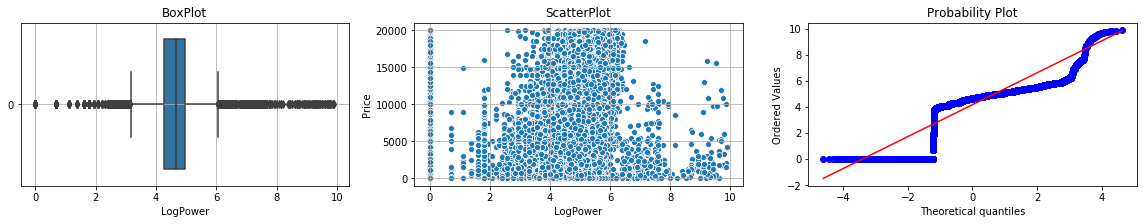

In [29]:
data['LogPower'] = np.log(1 + data['Power']) #добавляем 1, чтобы не считать Log(0)
draw_box_scat_plots(data, 'LogPower', 'Price')

Оставим значения только в пределах BoxPlot

In [30]:
quantiles = data['LogPower'].quantile([.25, .75])
koeff = 1.5
indent = koeff * (quantiles[0.75] - quantiles[0.25])
lower_limit = quantiles[0.25] - indent
upper_limit = quantiles[0.75] + indent
print(f'Нижний предел: {lower_limit:.2f}, верхний предел: {upper_limit:.2f}')

Нижний предел: 3.17, верхний предел: 6.05


In [31]:
clean_data = data.query('LogPower >= @lower_limit and LogPower <= @upper_limit').reset_index(drop=True)
previous_shape = data.shape[0]
new_shape = clean_data.shape[0]
print(f'Убрано {previous_shape - new_shape} объекта, сокращение на {1 - new_shape/previous_shape:.2%}')

Убрано 41364 объекта, сокращение на 11.67%


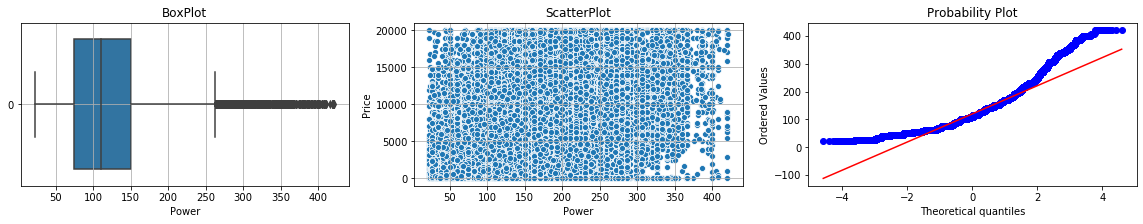

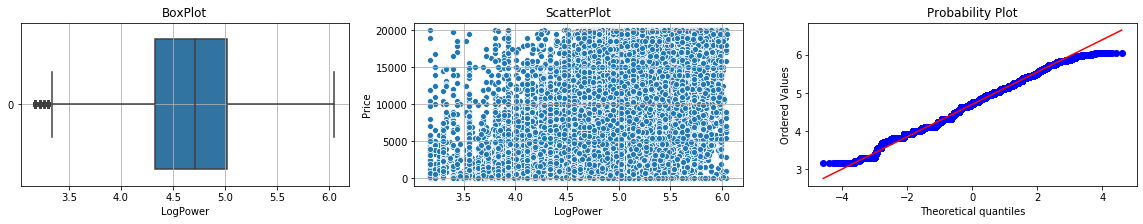

In [32]:
draw_box_scat_plots(clean_data, 'Power', 'Price')
draw_box_scat_plots(clean_data, 'LogPower', 'Price', )

Чуточку лучше

### RegistrationYear <a name='RegistrationYear'></a>

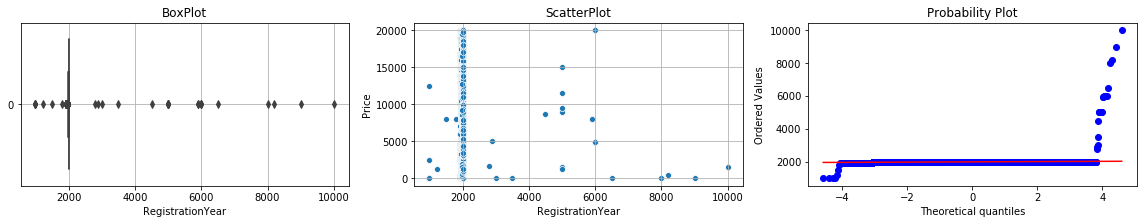

In [33]:
draw_box_scat_plots(clean_data, 'RegistrationYear', 'Price')

In [34]:
quantiles = clean_data['RegistrationYear'].quantile([.25, .75])
koeff = 3
indent = koeff * (quantiles[0.75] - quantiles[0.25])
lower_limit = quantiles[0.25] - indent
upper_limit = quantiles[0.75] + indent
print(f'Нижний предел: {lower_limit:.2f}, верхний предел: {upper_limit:.2f}')

Нижний предел: 1972.00, верхний предел: 2035.00


In [35]:
previous_shape = clean_data.shape[0]
clean_data = clean_data.query('RegistrationYear >= @lower_limit and RegistrationYear <= @upper_limit').reset_index(drop=True)
new_shape = clean_data.shape[0]
print(f'Убрано {previous_shape - new_shape} объекта, сокращение на {1 - new_shape/previous_shape:.2%}')

Убрано 964 объекта, сокращение на 0.31%


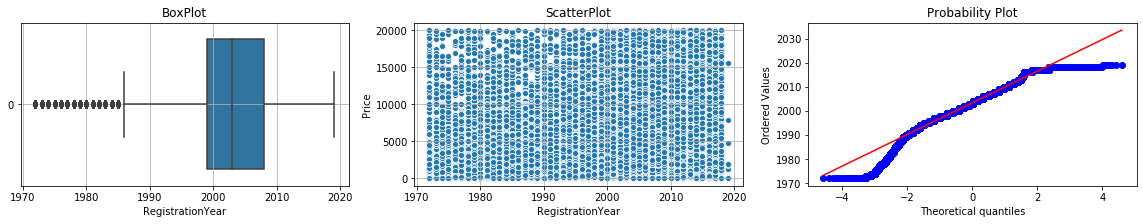

In [36]:
draw_box_scat_plots(clean_data, 'RegistrationYear', 'Price')

Отлично, машин из будущего не осталось

### Price <a name='Price'></a>

In [39]:
def draw_box_dist_plots(dataset, column):
    """
    imput:
    dataset - (DataFrame) данные по которым будут строится графики
    column - (str) Название столбца по которому строятся графики
    Строит три графика:
    1 - BoxPlot
    2 - DistPlot
    3 - QQPlot
    """
    f, ax = plt.subplots(ncols = 3, figsize=(20, 3))
    sns.boxplot(data=dataset[column], orient='h', ax=ax[0])
    ax[0].set_xlabel(column)
    ax[0].grid()
    ax[0].set_title('BoxPlot')
    sns.distplot(dataset[column], ax=ax[1], bins=100);
    ax[1].set_xlabel(column)
    ax[1].set_title('DistPlot')
    ax[1].grid()
    probplot(x=dataset[column], plot=ax[2])


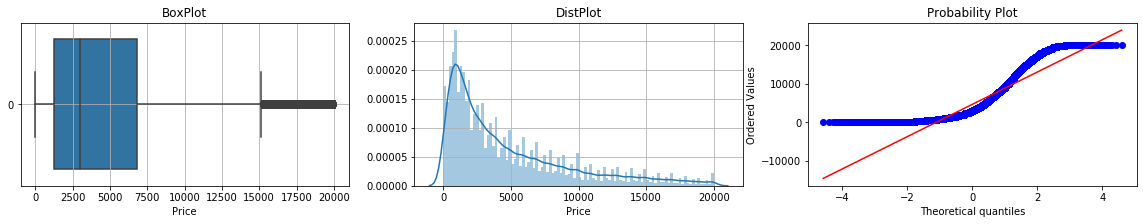

In [40]:
draw_box_dist_plots(clean_data, 'Price')

Снова у нас получается смещение вправо. Пробуем логарифмировать

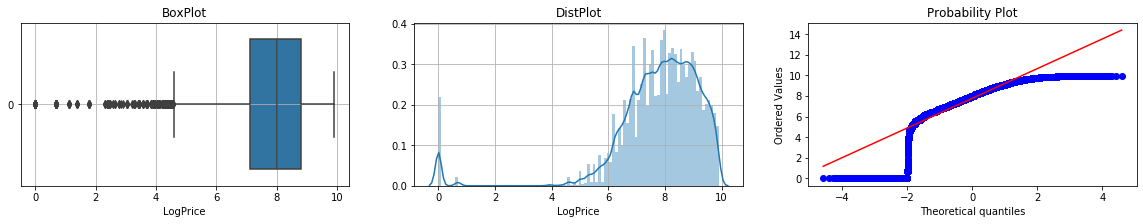

In [41]:
clean_data['LogPrice'] = np.log(1+clean_data['Price'])
draw_box_dist_plots(clean_data, 'LogPrice')

In [42]:
quantiles = clean_data['LogPrice'].quantile([.25, .75])
koeff = 1.5
indent = koeff * (quantiles[0.75] - quantiles[0.25])
lower_limit = quantiles[0.25] - indent
upper_limit = quantiles[0.75] + indent
print(f'Нижний предел: {lower_limit:.2f}, верхний предел: {upper_limit:.2f}')

Нижний предел: 4.59, верхний предел: 11.36


In [43]:
previous_shape = clean_data.shape[0]
clean_data = clean_data.query('LogPrice >= @lower_limit and LogPrice <= @upper_limit').reset_index(drop=True)
new_shape = clean_data.shape[0]
print(f'Убрано {previous_shape - new_shape} объекта, сокращение на {1 - new_shape/previous_shape:.2%}')

Убрано 7962 объекта, сокращение на 2.55%


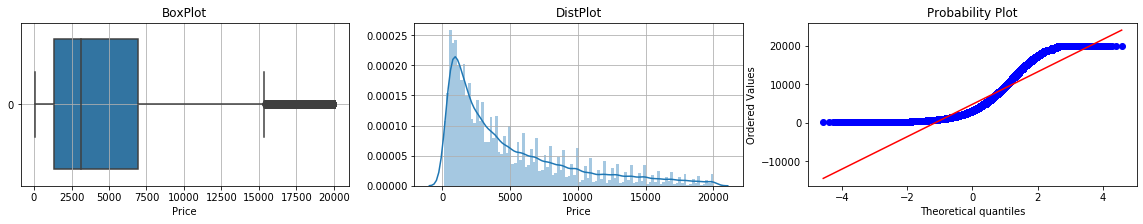

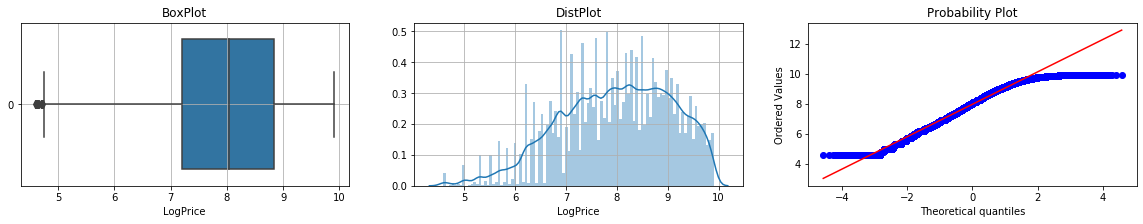

In [44]:
draw_box_dist_plots(clean_data, 'Price')
draw_box_dist_plots(clean_data, 'LogPrice')

Ну немного получше, больше удалять уже жалко. Думаю важнее было почистить нижние значения, а сделать распределение нормальным уже не так важно

In [45]:
previous_shape = data.shape[0]
current_shape = clean_data.shape[0]
print('Итого:')
print(f'Убрано {previous_shape - current_shape} объекта, сокращение на {1 - current_shape/previous_shape:.2%}')

Итого:
Убрано 50290 объекта, сокращение на 14.19%


## Заполнение пропусков <a name='Fillna'></a>

In [46]:
clean_data.isna().sum(axis=0)

DateCrawled              0
Price                    0
VehicleType          20947
RegistrationYear         0
Gearbox               5872
Power                    0
Model                11848
Kilometer                0
RegistrationMonth        0
FuelType             19340
Brand                    0
NotRepaired          46262
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
LogPower                 0
LogPrice                 0
dtype: int64

Все пропуски находятся в категориальных данных. Заполним все значениями 'n/a'

In [47]:
clean_data.fillna('n/a', inplace=True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304079 entries, 0 to 304078
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        304079 non-null  object 
 1   Price              304079 non-null  int64  
 2   VehicleType        304079 non-null  object 
 3   RegistrationYear   304079 non-null  int64  
 4   Gearbox            304079 non-null  object 
 5   Power              304079 non-null  int64  
 6   Model              304079 non-null  object 
 7   Kilometer          304079 non-null  int64  
 8   RegistrationMonth  304079 non-null  int64  
 9   FuelType           304079 non-null  object 
 10  Brand              304079 non-null  object 
 11  NotRepaired        304079 non-null  object 
 12  DateCreated        304079 non-null  object 
 13  NumberOfPictures   304079 non-null  int64  
 14  PostalCode         304079 non-null  int64  
 15  LastSeen           304079 non-null  object 
 16  Lo

## Train/Test split <a name='train_test_split'></a>

In [48]:
target = clean_data[['Price']]
features = clean_data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen',
                            'Price', 'LogPrice', 'LogPower', 'NumberOfPictures'], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((243263, 10), (60816, 10), (243263, 1), (60816, 1))

## Encoding and Scaling <a name='Encoding_and_Scaling'></a>

In [50]:
quant_columns = ['Kilometer', 'Power', 'RegistrationYear', 'RegistrationMonth']
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [51]:
ohe_encoder = OneHotEncoder(dtype=np.bool, sparse=False, handle_unknown='ignore')
X_train_ohe = ohe_encoder.fit_transform(X_train[cat_columns])
X_test_ohe = ohe_encoder.transform(X_test[cat_columns])
X_train_ohe.shape, X_test_ohe.shape

((243263, 313), (60816, 313))

In [52]:
ordinal_encoder = OrdinalEncoder(dtype=np.int16)
ordinal_encoder.fit(features[cat_columns])
X_train_ord = ordinal_encoder.transform(X_train[cat_columns])
X_test_ord = ordinal_encoder.transform(X_test[cat_columns])
X_train_ord.shape, X_test_ord.shape

((243263, 6), (60816, 6))

In [53]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train[quant_columns])
X_test_scal = scaler.transform(X_test[quant_columns])
X_train_scal.shape, X_test_scal.shape

((243263, 4), (60816, 4))

## Вывод: <a name='Finding_1'></a>
1. Почищены выбросы в Power, RegistrationYear и Price. Всего было удалено 50290 объектов, данные сократились на 14.2%.
2. Удалили признаки:
    * _DateCrawled_ - дата скачивания анкеты из базы;
    * _PostalCode_ - почтовый индекс владельца анкеты;
    * _LastSeen_ - дата последней активности пользователя;
    * _DateCreated_ - дата создания анкеты;
    * _NumberOfPictures_ - количество фотографий автомобиля (константный признак).
3. Пропуски находились только в категориальных признаках и были заполнены значением 'n/a'.
4. Разделены данные на Train/Test как 80/20
5. Признаки разделены на количественные (X_train_scal, X_test_scal) и категориальные(X_train_ohe, X_test_ohe)(X_train_ord, X_test_ord).
    * Количественные стандартизировали при помощи StandardScaler
    * Для категориальных признаков использовался OneHotEncoder и OrdinalEncoder

# 2. Обучение моделей <a name='model_fit'></a>

Попробуем 4 модели:
1. DummyRegressor
2. LinearRegression
3. CatBoostRegressor
4. LGBMRegressor

### DummyRegressor <a name='DummyRegressor'></a>

Для DummyRegressor'a неважно, какие признаки подавать, главное целевой признак

In [54]:
%%time
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)
predict = dummy_model.predict(X_train)
print(f'RMSE:{mse(y_train, predict)**0.5:.2f}')

RMSE:4568.12
Wall time: 7.53 ms


### LinearRegression <a name='LinearRegression'></a>

Для LinearRegression лучше подойдут OneHot features

In [55]:
X_train_scal_ohe = np.concatenate((X_train_ohe, X_train_scal), axis=-1)

In [56]:
%%time
linear_model = LinearRegression()
linear_model.fit(X_train_scal_ohe, y_train)
predict = linear_model.predict(X_train_scal_ohe)
print(f'RMSE:{mse(y_train, predict)**0.5:.2f}')

RMSE:2475.69
Wall time: 8.93 s


### CatBoostRegressor <a name='CatBoostRegressor'></a>

Для CatBoost и Lightgb понядобятся Ordinat features

In [134]:
X_train_ord_scale = pd.concat((pd.DataFrame(X_train_ord, columns=cat_columns),
                               pd.DataFrame(X_train_scal, columns=quant_columns)), axis=1)

In [58]:
train_pool = Pool(data=X_train_ord_scale, label=y_train, cat_features=cat_columns)
params = {"iterations": 400,
          "learning_rate": 1,
          "max_depth": None,
          "loss_function": "RMSE",
          "random_state": 42,
          "bootstrap_type": None,
          "min_data_in_leaf": 1,
          "boosting_type": 'Plain',
          "verbose": False}
bootstrap_type = ['MVS', 'Bernoulli']
max_depth = [2, 3, 4]

Wall time: 2.72 s


In [59]:
best_score = 10000
for trap_type in bootstrap_type:
    params['bootstrap_type'] = trap_type
    for m_depth in max_depth:
        params['max_depth'] = m_depth
        score = cv(pool=train_pool, params=params, fold_count=2, plot=False).iloc[-1]['test-RMSE-mean']
        if score < best_score:
            best_score = score
            best_param = (trap_type, m_depth)

In [60]:
print('Лучший RMSE:', best_score)

Лучший RMSE: 1666.723581594154


In [61]:
%%time
boots_type = best_param[0]
max_depth = best_param[1]
catboost_model = CatBoostRegressor(iterations=400, learning_rate=1, max_depth=max_depth, bootstrap_type=boots_type,
                       random_state=42, boosting_type='Plain', verbose=False)
catboost_model.fit(train_pool);

Wall time: 37 s


### LGBMRegressor <a name='LGBMRegressor'></a>

In [150]:
lgbm_train_data = lightgbm.Dataset(X_train_ord_scale, label=y_train, categorical_feature=cat_columns, free_raw_data=False)
param = {'learning_rate': 1,
         'metric': 'rmse',
         'stratify': False,
         'seed': 42,
         'objective': 'regression',
         'verbosity': -1,
        }
booster_method = ['gbdt', 'gross']
max_depth = [2, 3, 4]

In [ ]:
best_score = 10000
for boost in booster_method:
    params['boosting'] = boost
    for m_depth in max_depth:
        params['max_depth'] = m_depth
        score = lightgbm.cv(param, lgbm_train_data, nfold=3, categorical_feature=cat_columns)
        score = pd.DataFrame(score).iloc[-1]['rmse-mean']
        if score < best_score:
            best_score = score
            best_param = (boost, m_depth)

In [152]:
print('Лучший RMSE:', best_score)

Лучший RMSE: 1722.420904815967


In [153]:
%%time
param['max_depth'] = best_param[1]
param['boosting'] = best_param[0]
lgbm_model = lightgbm.train(param, lgbm_train_data, categorical_feature=cat_columns, num_boost_round=400)

Wall time: 1.27 s


## Вывод: <a name='Finding_2'></a>
1. Обучили 4 модели:
    * DummyRegressor: Обучение 7.53 мс и точность RMSE = 4568
    * LinearRegression: обучение 8.93 c, точность RMSE = 2476
    * CatBoostRegressor: время обучения 37 с, точность RMSE = 1667
    * LGBMRegressor: время обучения 1.27 с, точность RMSE = 1722

# 3. Анализ моделей <a name='model_predict'></a>

In [76]:
%%time
predict = dummy_model.predict(X_test)
print(f'DummyRegressor RMSE: {mse(y_test, predict)**0.5:.2f}')

DummyRegressor RMSE: 4573.47
Wall time: 5.59 ms


In [77]:
X_test_ord_scale = pd.concat((pd.DataFrame(X_test_ord, columns=cat_columns),
                               pd.DataFrame(X_test_scal, columns=quant_columns)), axis=1)
test_pool = Pool(data=X_test_ord_scale, cat_features=cat_columns)

In [78]:
%%time
predict = catboost_model.predict(test_pool)
print(f'CatBoostRegressor RMSE: {mse(y_test, predict)**0.5:.2f}')

CatBoostRegressor RMSE: 1613.46
Wall time: 58.4 ms


In [79]:
%%time
predict = lgbm_model.predict(X_test_ord_scale)
print(f'LGBMRegressor RMSE: {mse(y_test, predict)**0.5:.2f}')

LGBMRegressor RMSE: 1653.46
Wall time: 218 ms


### Вывод: <a name='Finding_3'></a>
CatBoostRegressor показал лучший RMSE: 1613, и время расчета 58.4 мс в то время как LGBMRegressor показал RMSE 1653 и время - 218 мс.

# Выводы: <a name='Finding'></a>
1. 1. Почищены выбросы в Power, RegistrationYear и Price. Всего было удалено 50290 объектов, данные сократились на 14.2%.
2. Удалили признаки:
    * _DateCrawled_ - дата скачивания анкеты из базы;
    * _PostalCode_ - почтовый индекс владельца анкеты;
    * _LastSeen_ - дата последней активности пользователя;
    * _DateCreated_ - дата создания анкеты;
    * _NumberOfPictures_ - количество фотографий автомобиля (константный признак).
3. Пропуски находились только в категориальных признаках и были заполнены значением 'n/a'.
4. Разделены данные на Train/Test как 80/20
5. Признаки разделены на количественные (X_train_scal, X_test_scal) и категориальные(X_train_ohe, X_test_ohe)(X_train_ord, X_test_ord).
    * Количественные стандартизировали при помощи StandardScaler
    * Для категориальных признаков использовался OneHotEncoder и OrdinalEncoder
4. Обучили 4 модели:
    * DummyRegressor: Обучение 7.53 мс и точность RMSE = 4568
    * LinearRegression: обучение 8.93 c, точность RMSE = 2476
    * CatBoostRegressor: время обучения 37 с, точность RMSE = 1667
    * LGBMRegressor: время обучения 1.27 с, точность RMSE = 1722
6. Для тестирования были выбраны LGBMRegressor и CatBoostRegressor т.к. у них обоих лучший RMSE. Результат тестирования показал, что точность у моделей примерно одинакова. CatBoostRegressor предсказывает в 8 раз быстрее.
7. Окончательной моделью лучше выбрать CatBoostRegressor

